# This tutorial is Largely based on the paper Context-aware Argumentative Relation Mining 
Huy V. Nguyen
Diane J. Litman

However the implementation is not the exact procedure stated in the paper, rather covers the overall intention.
The main intention being somehow give the contextual information to the classifier model by extracting topics using LDA.

The implementation is divided into 6 parts :
    
    Part 1 : Importing and structuring the Dataset 
    Part 2 : Window Context Extraction ( TODO )
    Part 3 : LDA topic Extraction ( TODO )
    Part 4 : Creating and Adding the features ( TODO )
    Part 5 : Applying Classification Models ( TODO )
    Part 6 : Hyperparameter tuning ( additional )

#### Library Installation cells. Uncomment them and run the cells. To be skipped if already installed

In [1]:
#!pip install numpy

In [2]:
#!pip install pandas

In [3]:
#!pip install sklearn

In [4]:
#!pip install imblearn 

In [5]:
#!pip install nltk

In [6]:
#!pip install gensim

In [7]:
import pandas as pd
import numpy as np
import itertools
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,phrases,Phrases


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
stop_words = stopwords.words('english')

# Part 1.
## Importing and structuring the Dataset of 90 Persuasive ESSAYs

#### Importing the actual essays

In [11]:
essay_dict = {}
for filename in os.listdir("brat-project"):
    if filename.endswith(".txt"): 
        
        filepath= os.path.join("brat-project", filename)
        #print(filepath,'\n')
        try:
            file =open(filepath,'r')
            essay = file.read()
            essay_dict.update({filename[:-4]:sent_tokenize(essay)})
            
        except IOError as err:
            print(err)

In [104]:
essay_dict['essay34']

['Study at school or get a job?',
 'Many people believe that children should study at school to have more knowledge that prepare better for their future.',
 'Others, however, think that these children may disrupt their school work and should be allowed to leave school early to find a job.',
 'Personally, I tend to agree with the point of view that student have to be forced to study at school.',
 'First of all, schools offer to students a good environment with experienced professors and high quality programs for studying.',
 'It creates the best conditions for students education and can force them to focus on their school work instead of wasting their time to do useless things.',
 'Second of all, schools provide lots of academic knowledge to students.',
 'Students may learn professional skills, expand their understandings and gain experiences.',
 'Therefore, they have more opprotunities to find a job and to be successful in the future.',
 'For example, as we know, employer always prefer

In [9]:
def rearrange_dataset(ann,essay):
    '''
        This function restructures the ADU segments such that the dataset contains all
        possible pairs of source - target permutations and the relation they share
    '''
    
    ann_ADU = ann[ann['ID'].str.startswith('T')] # this gets each ADU IDs
    ann_ADU_relations = ann[ann['ID'].str.startswith('R')][['ID','TYPE']] # this gets the relations between the ADU IDs

    
    # this creates a dataframe of ADU ID, segment, type and ADU start and end positions
    ann_ADU= pd.DataFrame(ann_ADU.apply(lambda x : 
                            list((x['ID'],)+(x['ADU'],) + tuple(x['TYPE'].split(' '))),axis=1).values.tolist(),
                          columns = ['ID','ADU','TYPE','strt','end']) 

    
    
    # this creates permutation of all ADUs with each other to form a source-target pair
    ann_ADU = pd.DataFrame([row[0]+ row[1] for row in itertools.permutations(
                                        ann_ADU[['ID','ADU','TYPE','strt','end']].values.tolist(), 2) ],
                            columns=['src_id','src','src_type','src_strt','src_end',
                                     'tgt_id','tgt','tgt_type','tgt_strt','tgt_end']) 

    # this creates a dataframe of ADU IDs and their relations
    ann_ADU_relations= pd.DataFrame(ann_ADU_relations.apply(lambda x : [x['TYPE'].split(' ')[0],
                                         x['TYPE'].split(' ')[1].split(':')[1],
                                         x['TYPE'].split(' ')[2].split(':')[1]] ,axis=1).values.tolist(), 
                 columns=['relation','src_id','tgt_id'])


    # finally the above two dataframes are joined together
    rearranged_ann = pd.merge(ann_ADU,ann_ADU_relations,on=['src_id','tgt_id'],how='outer')
    rearranged_ann.fillna('no relation',inplace=True)
    rearranged_ann['essay'] = essay
    
    return rearranged_ann

#### Importing the Annotations

In [10]:
dataset = pd.DataFrame()
for filename in os.listdir("brat-project"):
    if filename.endswith(".ann"): 
        
        filepath= os.path.join("brat-project", filename)
        #print(filepath,'\n')
        try:
            annotation = pd.read_table(filepath,header=None)
            annotation.columns =  ['ID','TYPE','ADU']
            dataset = dataset.append(rearrange_dataset(annotation,filename[:-4]))
        except pd.errors.ParserError as err:
            print(err)

In [106]:
dataset.head()

,src_id,src,src_type,src_strt,src_end,tgt_id,tgt,tgt_type,tgt_strt,tgt_end,relation,essay
0,T1,competition can effectively promote the develo...,Claim,78,140,T2,we should attach more importance to cooperation,MajorClaim,503,550,attacks,essay01
1,T1,competition can effectively promote the develo...,Claim,78,140,T3,"In order to survive in the competition, compan...",Premise,142,283,no relation,essay01
2,T1,competition can effectively promote the develo...,Claim,78,140,T4,"through cooperation, children can learn about ...",Claim,591,714,no relation,essay01
3,T1,competition can effectively promote the develo...,Claim,78,140,T5,What we acquired from team work is not only ho...,Premise,716,851,no relation,essay01
4,T1,competition can effectively promote the develo...,Claim,78,140,T6,"During the process of cooperation, children ca...",Premise,853,1086,no relation,essay01


In [12]:
dataset[dataset['relation'] != 'no relation']['relation'].value_counts()

supports    1312
attacks      161
Name: relation, dtype: int64

#### keeping only the 'supports' and 'attacks' relation in the dataset

In [13]:
dataset.reset_index(drop=True,inplace=True)
dataset_model2 = dataset.drop(dataset[dataset['relation'] == 'no relation'].index, axis=0)
dataset_model2.shape

(1473, 12)

# Part 2.
## Context Window Extraction


### TASK :
#### Implement a Loop for tokenizing each sentence contained in variable 'sent' and store it in 'sentToken' dictionary
       
       For example for some list of sentences in 'sent', 1 entry in the dictionary should look like :  
   
             { 6 : ['In', 'a', 'word', ',', 'the', 'notion', 'of', 'being', 'afraid',
                   'of', 'social', 'misleading', 'is', 'unjustified', '.'] }
    
       where key '6' refers to the sentence number in the list and the value is the tokenized sentence

In [14]:
def getSentNeigh(sent, segment,prefix, num_neighbours = 0): 
    '''
        This function gets the neighbouring window sentences(both previous and next) of the 
        current ADU segment, with a parameter (num_neighbours) to control the window size.
    '''
    
    sentToken = dict() 
    
    # Loop for tokenizing each sentence
    for s in range(len(sent)): 
        sentToken[s] = word_tokenize(sent[s])
              

    # tokenize the ADU segment
    wordList = word_tokenize(segment)
    res=-1

    # Then Check in every Sentence 
    for s in range(len(sentToken)): 
        wCount = len(wordList) 

        # Every word in the Phrase 
        for w in wordList: 
            if w in sentToken[s]: 
                wCount -= 1

        # If every word in phrase matches 
        if wCount == 0: 
            res= s 
            break

    if(res > -1): 

        ret_dict= {}

        for i in range(1,num_neighbours+1):

            ret_dict.update( {prefix+'_prev_sent'+str(i):[sent[res-i]]})

            # to check if the segment has neighbours left on its right.
            if res+i < len(sent):
                ret_dict.update( {prefix+'_next_sent'+str(i):[sent[res+i]]})

        return ret_dict

#### Getting then neighbouring sentences for each source and target pairs

In [15]:
# 40 - 60 secs atleast

window_size = 4

dataset_model2.reset_index(drop=True,inplace=True)
neighbours = pd.DataFrame()

for row in dataset_model2[['src','tgt','essay']].iterrows():
    
    essay_num = row[1]['essay']
    essay = essay_dict[essay_num]
    
    src_adu = row[1]['src']
    tgt_adu = row[1]['tgt']
    
    src = pd.DataFrame(getSentNeigh(sent = essay, 
                                    segment = src_adu ,
                                    prefix = 'src', 
                                    num_neighbours = window_size))
    
    tgt = pd.DataFrame(getSentNeigh(sent = essay, 
                                    segment = tgt_adu ,
                                    prefix = 'tgt', 
                                    num_neighbours = window_size))
    
    neighbours = neighbours.append(pd.concat([src,tgt],axis=1))
    
neighbours.reset_index(drop=True,inplace=True)

#### Adding the neighbours extracted to the dataset

In [16]:
neighbours = neighbours.fillna('')
dataset_model2  = pd.concat([dataset_model2,neighbours],axis=1)
dataset_model2.shape

(1473, 28)

# Part 3.
## LDA Topic Extraction 

#### Loading the extra Essay corpus

In [17]:
data=[]

for filename in os.listdir("developemental_data"):
    if filename.endswith(".txt"): 
        filepath= os.path.join("developemental_data", filename)
        #print(filepath,'\n')
        try:
            file =open(filepath,'r')
            data.append(file.readline())
            
        except IOError as err:
            print(err)

In [107]:
data[:5]

['Should students be taught to compete or to cooperate? ',
 'More people are migrating to other countries than ever before ',
 'International tourism is now more common than ever before ',
 'International tourism is now more common than ever before ',
 'Living and studying overseas ']

### TASK: 
#### Use the re library to remove single quotes and new line characters from each headings of all essays stored in variable data in previous step.

In [18]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#### Text preprocessing functions to tokenize, lemmatize and create bigrams or trigrams.

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

### TASK:
#### Implement the function to remove stopwords from each sentence contained in the texts variable.

In [20]:
def remove_stopwords(texts):
    
    return [[word for word in doc if word not in stop_words] for doc in texts]

### TASK : 
#### Complete the lemmatization function which checks for Parts of Speech tag to lemmatize each token. 
#### Hint : 
#### 1. Check the pos tag to identify if the token is a noun ('NN') or verb ('VB') or adjective ('JJ')
#### 2. Lemmatize each token by calling : lemmatizer.lemmatize(token, pos='n')

In [21]:
def lemmatization(texts):
    lemmatizer = WordNetLemmatizer()
    pos_tagged_text = [pos_tag(text) for text in texts]
    
    texts_lemmatized =[]
    for text in pos_tagged_text:
        text_lemmatized = []
        for token, tag in text:
            if tag.startswith("NN"):
                token = lemmatizer.lemmatize(token, pos='n')
            elif tag.startswith('VB'):
                token = lemmatizer.lemmatize(token, pos='v')
            elif tag.startswith('JJ'):
                token = lemmatizer.lemmatize(token, pos='a')
                
            text_lemmatized.append(token)
        texts_lemmatized.append(text_lemmatized)
    
    return texts_lemmatized

In [22]:
def make_bigrams(texts):
    # Build the bigram models
    bigram = Phrases(texts, min_count=2, threshold=1) # higher threshold fewer phrases.
    
    bigram_mod = phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    # Build the bigram and trigram models
    bigram = Phrases(texts, min_count=2, threshold=1) # higher threshold fewer phrases.
    trigram = Phrases(bigram[texts], min_count=2, threshold=1)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = phrases.Phraser(bigram)
    trigram_mod = phrases.Phraser(trigram)
    
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [23]:
def preprocess_pipeline(data):
    
    # sentence tokenize
    data_words = list(sent_to_words(data))
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Do lemmatization
    data_lemmatized = lemmatization(data_words_nostops)
    
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_lemmatized)

     # Form Trigrams
    data_words_trigrams = make_trigrams(data_lemmatized)
    
    return data_words_trigrams

print(preprocess_pipeline(data)[:10])

[['student', 'teach', 'compete', 'cooperate'], ['people', 'migrate', 'country', 'ever'], ['international_tourism', 'common', 'ever'], ['international_tourism', 'common', 'ever'], ['live', 'study', 'overseas'], ['exercise'], ['newspaper', 'become', 'thing', 'past'], ['technology', 'cannot', 'solve', 'world', 'problem'], ['truth', 'cannabis'], ['single', 'international', 'language']]


In [24]:
# Create Dictionary
id2word = corpora.Dictionary(preprocess_pipeline(data))

# Create Corpus
texts = preprocess_pipeline(data)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[9])

[(25, 1), (26, 1), (27, 1)]


In [25]:
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=10,
                                           passes=100,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)


'''


os.environ['MALLET_HOME'] = 'C:\\Users\\Arkajit\\Anaconda2\\envs\\TFENV\\mallet-2.0.8'

lda_model = gensim.models.wrappers.LdaMallet('C:\\Users\\Arkajit\\Anaconda2\\envs\\TFENV\\mallet-2.0.8\\bin\\mallet.bat',
                                            corpus=corpus,
                                            id2word=id2word,
                                            num_topics=36, 
                                            iterations=100
                                            )

In [26]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.7923088842456681


In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3,mallet = False):
    '''
        This function iterates the ldamodel over a series of different counts of topics and 
        stores its coherence Score
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        if ( mallet == False):
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           passes=100,
                                           alpha='auto',
                                           eta='auto')
        
        else :
            model = gensim.models.wrappers.LdaMallet('C:\\Users\\Arkajit\\Anaconda2\\envs\\TFENV\\mallet-2.0.8\\bin\\mallet.bat',
                                           corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           iterations=100
                                           )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

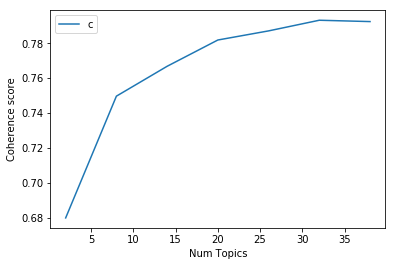

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        mallet=True)


limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

# Part 4.
## Creating and adding Features 

In [29]:
topic_words = [[word[0] for word in lda_model.show_topic(i,topn= 50)] for i in range(lda_model.num_topics)]

In [102]:
topic_words[13][:5]

['influence', 'artist', 'improve', 'rich', 'university']

#### 1. Topic words common between source and target ADUs

### Task : 
#### Get the number of common tokens between the topic_words and src_ADU and tgt_ADU and store it it in context_words_lda

In [30]:
src_ADU = preprocess_pipeline(dataset_model2['src'].values)
tgt_ADU = preprocess_pipeline(dataset_model2['tgt'].values)

context_words_lda = []
column_names = []

for i, topic in enumerate(topic_words):
    
    context_words_lda.append([ len(np.intersect1d(topic,sent)) for sent in src_ADU])
    context_words_lda.append([ len(np.intersect1d(topic,sent)) for sent in tgt_ADU])
    column_names.append('topic_'+str(i)+'_src')
    column_names.append('topic_'+str(i)+'_tgt')
    
context_words_lda = pd.DataFrame(np.array(context_words_lda).T, columns = column_names )

#### 2. Common tokens between source and target ADUs and 8-window context sentences

In [31]:
# runtime: depending on window size atleast 30 secs

common_neigh=pd.DataFrame()
for col in neighbours.columns:
    
    if 'src' in col:
        temp = pd.DataFrame([len(np.intersect1d(simple_preprocess(str(sent[1]), deacc=True),
                                                simple_preprocess(str(sent[0]), deacc=True))) 
                             for sent in dataset_model2[['src',col]].values],
                             columns = [col+'_comm'])
    elif 'tgt' in col:
        temp = pd.DataFrame([len(np.intersect1d(simple_preprocess(str(sent[1]), deacc=True),
                                                simple_preprocess(str(sent[0]), deacc=True))) 
                             for sent in dataset_model2[['tgt',col]].values],
                             columns = [col+'_comm'])
    
    common_neigh = pd.concat([common_neigh,temp],axis=1)

column_names.extend(common_neigh.columns)

 #### 3. Word counts of source and target ADUs

In [32]:
word_count_src = [len(sent) for sent in dataset_model2['src'].values ]
word_count_tgt = [len(sent) for sent in dataset_model2['tgt'].values ]

word_counts = [word_count_src, word_count_tgt ] 
word_counts = pd.DataFrame(np.array(word_counts).T, columns = ['word_count_src', 'word_count_tgt' ] )

column_names.extend( ['word_count_src', 'word_count_tgt' ])

#### 4. Boolean features of source and target ADU types (premise, claim and major claim)

In [33]:
src_tgt_type= pd.get_dummies(dataset_model2[['src_type','tgt_type']])

column_names.extend(src_tgt_type.columns)

#### 5. Absolute differences between the positions of the source and target ADUs

In [34]:
abs_diff_strt = pd.DataFrame(np.abs(dataset_model2['tgt_strt'].astype('int') - dataset_model2['src_strt'].astype('int')),
                             columns=['abs_diff_strt'])
abs_diff_end = pd.DataFrame(np.abs(dataset_model2['tgt_end'].astype('int') -  dataset_model2['src_end'].astype('int')),
                            columns=['abs_diff_end'])

column_names.extend(['abs_diff_strt','abs_diff_end'] )

#### Joining all the above feature vectors into a training dataset and seperating out the target variable

In [93]:
X =pd.concat([src_tgt_type,
              abs_diff_strt,
              abs_diff_end,
              word_counts,
              common_neigh,
              context_words_lda],axis=1)

Y= dataset_model2['relation'].astype('category').cat.codes

In [95]:
X.head()

,src_type_Claim,src_type_Premise,tgt_type_Claim,tgt_type_MajorClaim,tgt_type_Premise,abs_diff_strt,abs_diff_end,word_count_src,word_count_tgt,src_next_sent1_comm,...,topic_31_src,topic_31_tgt,topic_32_src,topic_32_tgt,topic_33_src,topic_33_tgt,topic_34_src,topic_34_tgt,topic_35_src,topic_35_tgt
0,1,0,0,1,0,425,410,62,47,2,...,0,0,0,0,1,0,0,0,0,0
1,0,1,1,0,0,64,143,141,62,4,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,1,0,88,164,123,47,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,125,137,135,123,6,...,1,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,262,372,233,123,6,...,1,0,2,0,1,0,1,0,1,0


# Part 5.
## Applying Classification models

In [36]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV , SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import make_scorer,f1_score , recall_score, precision_score,accuracy_score,precision_recall_fscore_support,cohen_kappa_score,confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_validate,train_test_split,ShuffleSplit,KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA


from imblearn import over_sampling, under_sampling

 ### Scale the independant variables

In [37]:
s_scaler  = StandardScaler()#Normalizer()#MinMaxScaler()#
X = s_scaler.fit_transform(X)

### Task : 
#### Split X and Y into training and testing datasets using train_test_split. 

In [88]:
X_train ,X_test, Y_train ,  Y_test = train_test_split(X, 
                                                      Y, 
                                                      test_size=0.2,
                                                      random_state=0)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1178, 97) (1178,) (295, 97) (295,)


In [85]:
#sampler=over_sampling.SVMSMOTE(sampling_strategy= 0.8)
#X_train, Y_train=sampler.fit_resample(X_train,Y_train)

 #### Apply the best Classification model

In [89]:
model = SVC(C=37,class_weight='balanced')

model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

#### Calculating the precision macro, recall macro, f1 macro and accuracy of the model

In [90]:
p_macro, r_macro, f_macro, support_macro = precision_recall_fscore_support(y_true=Y_test, 
                                                                           y_pred=Y_pred, 
                                                                           labels=[0,1], 
                                                                           average='macro')

print('Accuracy:',round(accuracy_score(Y_test, Y_pred),2),
      '\nKappa:',round(cohen_kappa_score(Y_test,Y_pred),2),
      '\nMacro Precision:',round(p_macro,2),
      '\nMacro Recall:', round(r_macro,2),
      '\nMacro F1:',round(f_macro,2,),
      '\nF1:',round(f1_score(Y_test, Y_pred),2,)
      )

Accuracy: 0.87 
Kappa: 0.24 
Macro Precision: 0.68 
Macro Recall: 0.59 
Macro F1: 0.61 
F1: 0.93


# Part 6.
## Hyperparameter tuning

In [79]:
cv = KFold(n_splits=5)#ShuffleSplit(n_splits=10, test_size=0.25,random_state=0)

scoring = ['precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(model, X, Y, scoring=scoring, cv=cv)
scores['test_precision_macro'].mean(),scores['test_recall_macro'].mean(),scores['test_f1_macro'].mean()

(0.5108049597020584, 0.5064966760713203, 0.5048243968181988)

In [43]:
scorers = {
    'precision_score': make_scorer(precision_score,labels=[0,1],average='macro'),
    'recall_score': make_scorer(recall_score,labels=[0,1],average='macro'),
    'f1_score': make_scorer(f1_score,labels=[0,1],average='macro')
}

In [80]:
param_test1 = {
    'C': [c for c in range(1,120,2)]
}

clf = SVC(class_weight='balanced')#GradientBoostingClassifier(random_state = 42)#RandomForestClassifier(class_weight='balanced_subsample')#

gsearch1 = GridSearchCV(
    n_jobs=-1,
    estimator=clf, 
    param_grid=param_test1,
    scoring= scorers,
    verbose= True,
    iid=True,
    refit='f1_score',
    cv=KFold(n_splits=5))

gsearch1.fit(X_train, Y_train)

gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


({'C': 37}, 0.7355946222338455)

In [81]:
pd.DataFrame.from_dict(gsearch1.cv_results_)[[
       #'param_max_depth', 'param_n_estimators', 
      'params',
       'rank_test_precision_score',
       'rank_test_recall_score', 
       'rank_test_f1_score', 
        ]]

,params,rank_test_precision_score,rank_test_recall_score,rank_test_f1_score
0,{'C': 1},60,60,60
1,{'C': 3},59,59,59
2,{'C': 5},58,58,58
3,{'C': 7},57,57,57
4,{'C': 9},56,56,56
5,{'C': 11},55,55,55
6,{'C': 13},54,54,54
7,{'C': 15},53,53,53
8,{'C': 17},52,32,52
9,{'C': 19},51,31,51


In [ ]:
from scipy.stats import rv_discrete

depths = rv_discrete(values= ([i for i in range(1,6,1)], [0.2]*5))
n_iterations = rv_discrete(values = ([i for i in range(100,2100,50)],[0.025]*40))

In [ ]:
param_test1 = {
    #'C': C,
    #'class_weight':[{0: 7},{0:8},{0:9}]
    "n_estimators":n_iterations,
    'max_depth': depths,
}

clf = GradientBoostingClassifier(random_state = 42)#RandomForestClassifier(class_weight='balanced_subsample')#SVC()

gsearch1 = RandomizedSearchCV(
    n_jobs=-1,
    estimator=clf, 
    param_distributions=param_test1,
    scoring= scorers,#'precision_macro',
    verbose= True,
    iid=True,
    refit='precision_score',
    n_iter= 100,
    cv=cv)

gsearch1.fit(X, Y)

gsearch1.best_params_, gsearch1.best_score_